# I. Introduction

![Simulated Annealing](SA_animation.gif)
[simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

In [1]:
import json
import copy
import math
import sys

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
# import random  # alternative to numpy.random module

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
# OK so this just reads the image and stores it as a map variable.
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
# with open is new to me. as is the r argument, it's just a best practice thing. I don't think the r means anything.
#It's just a way to make sure the file closes properly when we're done running the program I suppose.
with open('capitals.json', 'r') as capitals_file:
    #This loads the json file and stores it as capitals.
    capitals = json.load(capitals_file)

#This turns the capitals into a list.
capitals_list = list(capitals.items())

#This little guy makes a path and shows it on the map. They don't really say what everything does so I'm going to annotate it.
def show_path(path, starting_city, w=20, h=20):
    """
    This function takes path, and starting city as an argument.
    This fuunction outputs the graph showing our salesman's pathway.
    """
    
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    
    #So path is fed to this variable and we use the splat operator on it to split evrything up within it.
    #Zip is then called on it so that the x's and y's are stored next to each other respectively
    #Then we list it, because duh, we want x and y to store their respective parts as a list.
    x, y = list(zip(*path))
    
    #So we don't care about the starting city, it gets a placeholder. variable. x0, y0 are stored.
    _, (x0, y0) = starting_city
    
    #now we use a bunch of mtpltlib jargon. show gives us the map.
    plt.imshow(map)
    #This plots the starting point and the star. It also gives us our star size. 
    plt.plot(x0, y0, 'y*', markersize=10)  # y* = yellow star for starting point
    
    #This is a bit confusing, but :1 is the startign point. this plots the line for us. it's stored as a list of points.
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    
    #No axis.
    plt.axis("off")
    
    #gcf is the type of graph.
    fig = plt.gcf()
    
    #This is the size of the graph.
    fig.set_size_inches([w, h])

## II. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [6]:

def probability(p):
    """
    This is a probability function. It takes in one arguement number.
    If p is greater than whaterver the random number 0-1 will be the function returns true.
    
    Very complex equestion.
    """
    return p > random.uniform(0.0, 1.0)

In [7]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time. [Norvig, AIMA Chapter 3]
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
        
    Notes
    -----
        (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode

        (2) Modify the termination condition to return when the temperature
        falls below some reasonable minimum value (e.g., 1e-10) rather than
        testing for exact equality to zero
        
    See Also
    --------
    AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    """     
    """
    Pseudocode: 
    
function SIMULATED-ANNEALING(problem,schedule) returns a solution state
    inputs: problem, a problem
        schedule, a mapping from time to "temperature"

    current ← MAKE-NODE(problem.INITIAL-STATE)
    for t = 1 to ∞ do
        T ← schedule(t)
       if T = 0 then return current
       next ← a randomly selected successor of current
       ΔE ← next.VALUE - current.VALUE
       if ΔE > 0 then current ← next
       else current ← next only with probability eΔE/T
    
    """
    
    #What is our initial and current state?
    #Luckily, we are fed problem.
    current_state = problem
    
    #This is the lowest energy we want in our system before we cease the reaction. I pulled this out of thin air.
    lowest_possible_energy = 0.0000001
    
    #This is us, looping based on our scheduled temperature reduction regimen.
    for t in range(sys.maxsize):
        T = schedule(t)
        
        #If our temperature is less than or equal to the lowest possible energy state:
        if T <= lowest_possible_energy:
            return current_state
        
        #If we're not at the minimum energy state we still have moves to make.
        #The next move's change difference depends on the total energy in the system.
        #Lower energies mean lower changes.
        #Our successors will store this information.
        next_move = random.choice(current_state.successors())
        
        #If we don't have a next move it means we're done.
        if not next_move:
            return current_state
        
        #This is the energy difference in the current state and the next state.
        #Remember, molecules want the lowest energy state possible. This is what we're modeling.
        energy_state_change = next_move.get_value() - current_state.get_value()
        
        #If the next energy state is not lower than the current energy state...
        #OR the probability of a change is high due to temperture...
        if energy_state_change > 0 or probability(math.exp(energy_state_change / T)):
            
            #Then the next state is now our current state.
            #REMEMBER: This happens at high temperatures.
            #Or when the change in energy for the next energy state is minimal.
            current_state = next_move

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [14]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Students should only need to implement or modify the successors() and
    get_values() methods.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    
    #So they decided to tell us nothing about this part again.
    #This looks scary, but it really doesn't mean anything.
    #We're making a copy of cities, but we're also making copies of the objects that cities links to.
    #This is our path.
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    #Pretty self explanatory here. This recursively calls the new path.
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    #oooo @property. Almost means nothing. 
    #Just some stuff with getters, setters and calling property().
    #I don't think it's even necessary in this code.
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        #gets the city names from self path. ignores the after cities objects.
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        #This gets us our coordinates. same as above except x, y stored as a list.
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        #This was not independently developed by me. This was a very hard portion of this lab and I had troouble starting it.
        
        #NOTE: This code needs to be reviewed and revised for consistency with something I would do.
        #NOTE: it has. *checkmark*
        
        #First we need a space to store our neighbors:
        neighbors = []
        
        #How many neighbors do we even have?
        number_of_neighbors = len(self.path)
        
        #For each location of the neighbor in out path...
        for i in range(0, number_of_neighbors):
            
            #Make a copy of our path:
            copy = self.path[:]
            
            #Take a temporary point at that copy:
            temp = copy[i]
            
            #If the index is equal to the iteration before the last iteration (our starting point):
            if i == (number_of_neighbors - 1):
                
                #Then we need to take note of the index and re-order our path.
                
                #the current iteration is now equal to the starting point.
                copy[i] = copy[0]
                
                #The temp is now equal to the last destination before going home.
                copy[0] = temp
                
            #If not then...    
            else:
                #then copy is is just i+1
                copy[i] = copy[i+1]
                #copy i+1 is now the temp.
                copy[i+1] = temp
            
            #We finish this by running the traveling salesmen problem for this iteration and inserting it to neighbors
            #We return the full neighbors object after everything has been completed
            neighbors.insert(i, TravelingSalesmanProblem(copy))
        return neighbors

        
        
        

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  Since
        the default simulated annealing algorithm seeks to maximize the objective
        function, return -1x the path length. (Multiplying by -1 makes the smallest
        path the smallest negative number, which is the maximum value.)
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city
            
            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """
        #Create a variable to store our total disatance:
        total_distance = 0
        
        #Number of travels
        number_of_neighbors = len(self.path)
        
        #For each index in our travels:
        for i in range(0, number_of_neighbors):
        
            #Create a copy of the path
            copy = self.path[:]
            
            #set x1 and y1 notice
            #NOTE: i is our current city,
            #NOTE: place @ the spot 1 in i is the x and y variable for this spot.
            x1, y1 = copy[i][1]
            
            #If the index is about to run the last itertation...
            #AKA, we're about to go home...
            if i == (number_of_neighbors - 1):
                
                #backtrack to first city:
                x2, y2 = copy[0][1]
                
            #If not, then on to the next one.
            else:
                x2, y2 = copy[i + 1][1]
            
            #get the hypotenuse.
            total_distance += math.hypot(x2 - x1, y2 - y1) * -1
            
        #boom.
        return total_distance

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [15]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [16]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [17]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## IV. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

In [18]:
# These are presented as globals so that the signature of schedule()
# matches what is shown in the AIMA textbook; you could alternatively
# define them within the schedule function, use a closure to limit
# their scope, or define an object if you would prefer not to use
# global variables
alpha = 0.95
temperature=1e4

def schedule(time):
    return(alpha**time)*temperature

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [19]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [20]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('PHX', (2, -3)), ('LA', (0, -4)), ('SF', (0, 0)), ('DC', (11, 1))]


## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

You can increase the `num_cities` parameter up to 30 to experiment with increasingly larger domains.  Try running the solver repeatedly -- how stable are the results?

Initial path value: 8119.82
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0]), ('Salem', [80.0, 139.2]), ('Little Rock', [469.2, 367.2]), ('Richmond', [673.2, 293.6]), ('Jackson', [501.6, 409.6]), ('Des Moines', [447.6, 246.0]), ('Lansing', [563.6, 216.4]), ('Denver', [293.6, 274.0]), ('Boise', [159.6, 182.8]), ('Raleigh', [662.0, 328.8]), ('Atlanta', [585.6, 376.8]), ('Madison', [500.8, 217.6]), ('Indianapolis', [548.0, 272.8]), ('Nashville', [546.4, 336.8]), ('Columbia', [632.4, 364.8]), ('Providence', [735.2, 201.2]), ('Boston', [738.4, 190.8]), ('Tallahassee', [594.8, 434.8]), ('Sacramento', [68.4, 254.0]), ('Albany', [702.0, 193.6]), ('Harrisburg', [670.8, 244.0])]


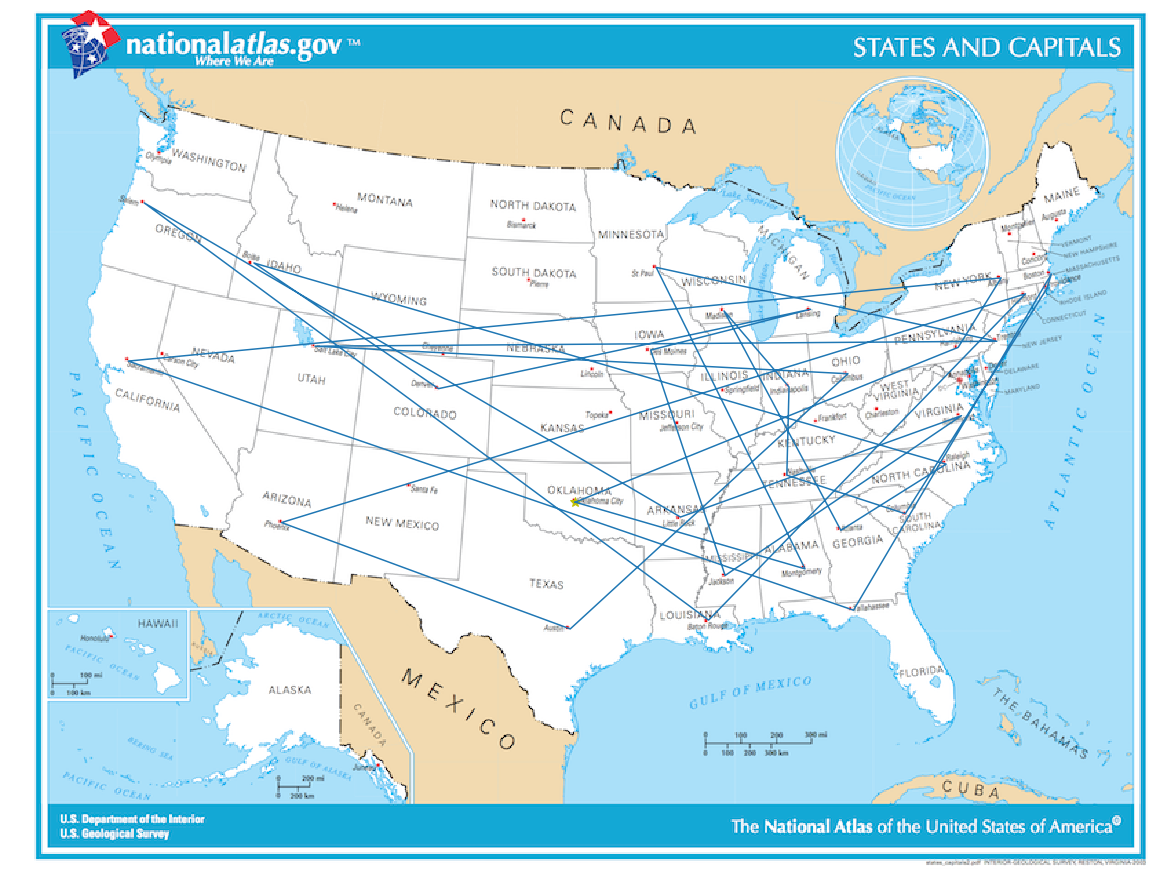

In [23]:
# Create the problem instance and plot the initial state
num_cities = 30
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

Final path length: 5442.37
[('Harrisburg', [670.8, 244.0]), ('Trenton', [698.8, 239.6]), ('Albany', [702.0, 193.6]), ('Columbus', [590.8, 263.2]), ('Baton Rouge', [489.6, 442.0]), ('Sacramento', [68.4, 254.0]), ('Phoenix', [179.6, 371.2]), ('Austin', [389.2, 448.4]), ('Salt Lake City', [204.0, 243.2]), ('Salem', [80.0, 139.2]), ('Jackson', [501.6, 409.6]), ('Hartford', [719.6, 205.2]), ('Richmond', [673.2, 293.6]), ('Atlanta', [585.6, 376.8]), ('Little Rock', [469.2, 367.2]), ('Des Moines', [447.6, 246.0]), ('Denver', [293.6, 274.0]), ('Boise', [159.6, 182.8]), ('Lansing', [563.6, 216.4]), ('Raleigh', [662.0, 328.8]), ('Columbia', [632.4, 364.8]), ('Nashville', [546.4, 336.8]), ('Indianapolis', [548.0, 272.8]), ('Madison', [500.8, 217.6]), ('Providence', [735.2, 201.2]), ('Boston', [738.4, 190.8]), ('Saint Paul', [451.6, 186.0]), ('Montgomery', [559.6, 404.8]), ('Tallahassee', [594.8, 434.8]), ('Oklahoma City', [392.8, 356.4])]


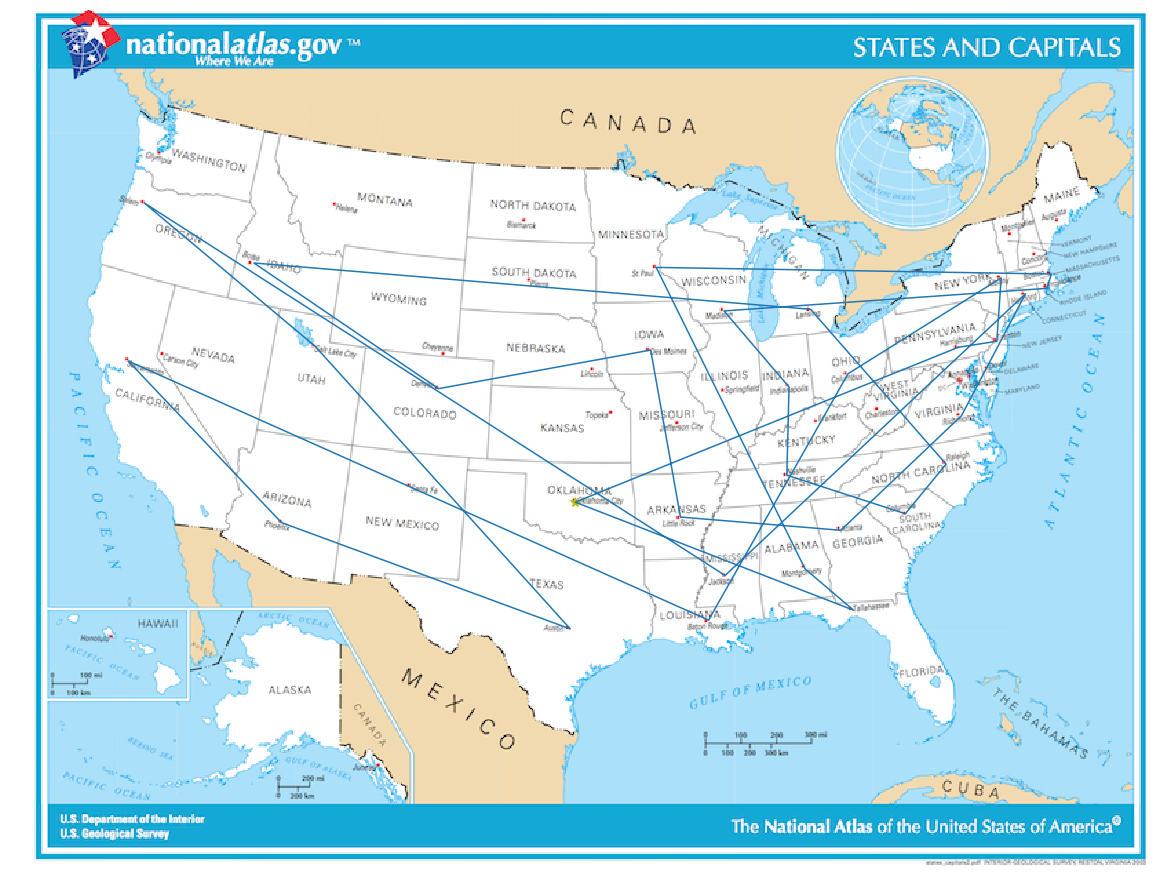

In [24]:
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

### Experiments (Optional)
Here are some ideas for additional experiments with various settings and parameters once you've completed the lab.

- Change the number of cities in the final map (between 10 and 30).  How are your results affected?  Why?
- Change the alpha and temperature parameters.  How do they affect the results?
- Use a different schedule function (something other than exponential decay).  Is the algorithm still effective?
- Use a different successors function; e.g., generate successors of a state by swapping _any_ pair of cities in the path, rather than only adjacent cities.  Try defining your own successor function.  What effect does the change have?
- Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance) or L$\infty$-norm (uniform norm)

Share and discuss your results with others in the forums!

In [26]:
#The increased number of cities just increases processing time because we have a larger search space.
#Changing the params and the method is useless for this project.
#We can use whatever decay, linear, polynomial, whatever, doesn't matter it's just a type of decay that we can optimize.
#I'll thank about this one. This is good.
#Doesn't matter here, flights are in straight paths almost so idk why we'd score it differently.